In [2]:
import pandas as pd
data = pd.read_csv("student_math_clean.csv")
print("Dataset Preview: ")
data.head(10)

print(data.info())

Dataset Preview: 
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 395 entries, 0 to 394
Data columns (total 34 columns):
 #   Column                 Non-Null Count  Dtype 
---  ------                 --------------  ----- 
 0   student_id             395 non-null    int64 
 1   school                 395 non-null    object
 2   sex                    395 non-null    object
 3   age                    395 non-null    int64 
 4   address_type           395 non-null    object
 5   family_size            395 non-null    object
 6   parent_status          395 non-null    object
 7   mother_education       395 non-null    object
 8   father_education       395 non-null    object
 9   mother_job             395 non-null    object
 10  father_job             395 non-null    object
 11  school_choice_reason   395 non-null    object
 12  guardian               395 non-null    object
 13  travel_time            395 non-null    object
 14  study_time             395 non-null    object
 15  class

In [3]:
data_encoded = pd.get_dummies(data, drop_first=True)
print('Encoded Data Preview')
print(data_encoded.head())

Encoded Data Preview
   student_id  age  class_failures  family_relationship  free_time  social  \
0           1   18               0                    4          3       4   
1           2   17               0                    5          3       3   
2           3   15               3                    4          3       2   
3           4   15               0                    3          2       2   
4           5   16               0                    4          3       2   

   weekday_alcohol  weekend_alcohol  health  absences  ...  \
0                1                1       3         6  ...   
1                1                1       3         4  ...   
2                2                3       3        10  ...   
3                1                1       5         2  ...   
4                1                2       5         4  ...   

   study_time_<2 hours  study_time_>10 hours  school_support_yes  \
0                False                 False                True   
1

In [4]:
# Define a binary target based on a threshold on 'final_grade'
# Here, 10 is chosen as the threshold; adjust as needed
data_encoded['graduation_likelihood'] = (data_encoded['final_grade'] >= 10).astype(int)

# Check the distribution of the target variable
print("\nTarget Distribution (Graduation Likelihood):")
print(data_encoded['graduation_likelihood'].value_counts())



Target Distribution (Graduation Likelihood):
graduation_likelihood
1    265
0    130
Name: count, dtype: int64


In [5]:
# Drop unnecessary columns
features = data_encoded.drop(columns=['student_id', 'final_grade', 'graduation_likelihood'])
target = data_encoded['graduation_likelihood']

# Display the shape of the features and target to confirm
print("\nFeatures Shape:", features.shape)
print("Target Shape:", target.shape)



Features Shape: (395, 51)
Target Shape: (395,)


In [6]:
from sklearn.model_selection import train_test_split

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(features, target, test_size=0.2, random_state=42)

# Confirm the split by checking shapes
print("\nTraining Set Shape (X_train):", X_train.shape)
print("Testing Set Shape (X_test):", X_test.shape)
print("Training Target Shape (y_train):", y_train.shape)
print("Testing Target Shape (y_test):", y_test.shape)



Training Set Shape (X_train): (316, 51)
Testing Set Shape (X_test): (79, 51)
Training Target Shape (y_train): (316,)
Testing Target Shape (y_test): (79,)


In [8]:
## BUILDING THE MODEL
from sklearn.ensemble import RandomForestClassifier

# Initialize the Random Forest Classifier
rf_model = RandomForestClassifier(random_state=42)
# Fit the model on the training data
rf_model.fit(X_train, y_train)

print("Model Training Complete")



Model Training Complete


In [9]:
# Predict on the test set
y_pred = rf_model.predict(X_test)

# Display a few predictions for review
print("\nSample Predictions:")
print(y_pred[:10])



Sample Predictions:
[0 1 0 1 0 1 1 0 0 1]


In [10]:
## EVALUATE MODEL PERFORMANCE
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

# Calculate evaluation metrics
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)

print("\nModel Evaluation Metrics:")
print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)
print("F1 Score:", f1)



Model Evaluation Metrics:
Accuracy: 0.9113924050632911
Precision: 0.9591836734693877
Recall: 0.9038461538461539
F1 Score: 0.9306930693069307


ANALYZING FEATURE IMPORTANCE:


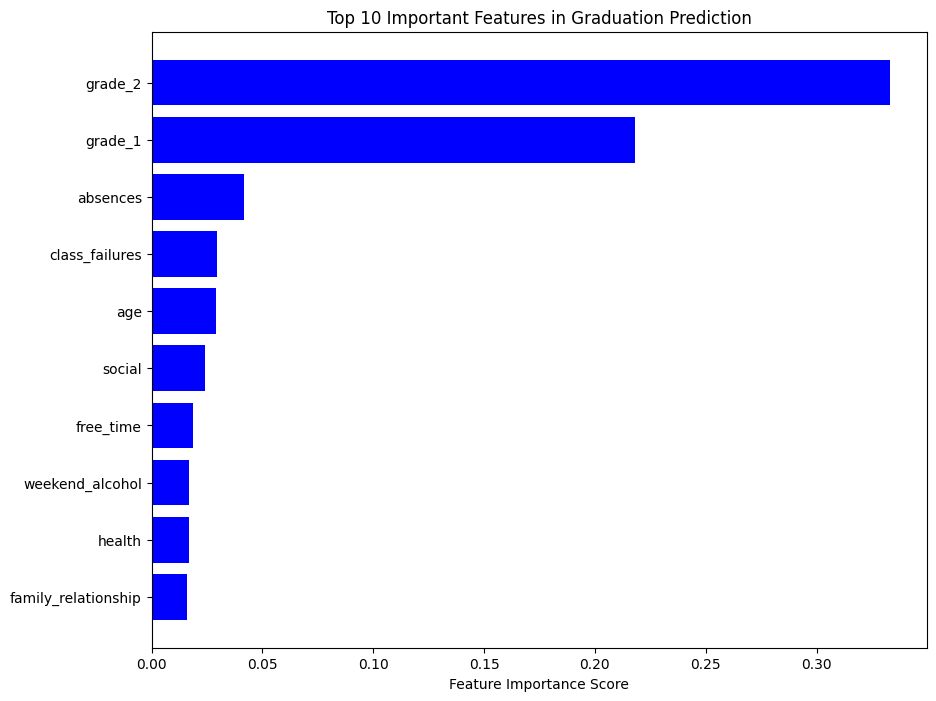

In [11]:
print("ANALYZING FEATURE IMPORTANCE:")
import matplotlib.pyplot as plt

# Get feature importances and sort them
importances = rf_model.feature_importances_
indices = importances.argsort()[::-1]  # Sort in descending order
features_sorted = [features.columns[i] for i in indices]

# Plot feature importances
plt.figure(figsize=(10, 8))
plt.barh(features_sorted[:10], importances[indices][:10], color="b")
plt.xlabel("Feature Importance Score")
plt.title("Top 10 Important Features in Graduation Prediction")
plt.gca().invert_yaxis()
plt.show()


In [12]:
## FINE TUNING THE MODEL PERFORMANCE BY ADJUSTING HYPERPARAMETERS
from sklearn.model_selection import GridSearchCV

# Define the parameter grid
param_grid = {
    'n_estimators': [50, 100, 150],          # Number of trees
    'max_depth': [None, 10, 20, 30],         # Max depth of each tree
    'min_samples_split': [2, 5, 10]          # Minimum samples for splitting
}

# Initialize GridSearchCV with the Random Forest model and parameter grid
grid_search = GridSearchCV(estimator=rf_model, param_grid=param_grid, cv=5, scoring='accuracy', n_jobs=-1)

# Fit GridSearchCV
grid_search.fit(X_train, y_train)

# Display the best parameters and best score
best_params = grid_search.best_params_
best_score = grid_search.best_score_

print("\nBest Parameters:", best_params)
print("Best Cross-Validation Score:", best_score)



Best Parameters: {'max_depth': None, 'min_samples_split': 2, 'n_estimators': 150}
Best Cross-Validation Score: 0.9144841269841268


In [13]:
# TRAIN OPTIMIZED MODEL WITH BEST PARAMETERS
# Initialize the Random Forest model with the best parameters
optimized_rf_model = RandomForestClassifier(**best_params, random_state=42)

# Train the optimized model
optimized_rf_model.fit(X_train, y_train)

print("\nOptimized Model Training Complete")



Optimized Model Training Complete


In [14]:
# EVALUATE OPTIMIZED MODEL
# Predict on the test set with the optimized model
y_pred_optimized = optimized_rf_model.predict(X_test)

# Calculate evaluation metrics
accuracy_opt = accuracy_score(y_test, y_pred_optimized)
precision_opt = precision_score(y_test, y_pred_optimized)
recall_opt = recall_score(y_test, y_pred_optimized)
f1_opt = f1_score(y_test, y_pred_optimized)

print("\nOptimized Model Evaluation Metrics:")
print("Accuracy:", accuracy_opt)
print("Precision:", precision_opt)
print("Recall:", recall_opt)
print("F1 Score:", f1_opt)



Optimized Model Evaluation Metrics:
Accuracy: 0.9113924050632911
Precision: 0.9591836734693877
Recall: 0.9038461538461539
F1 Score: 0.9306930693069307


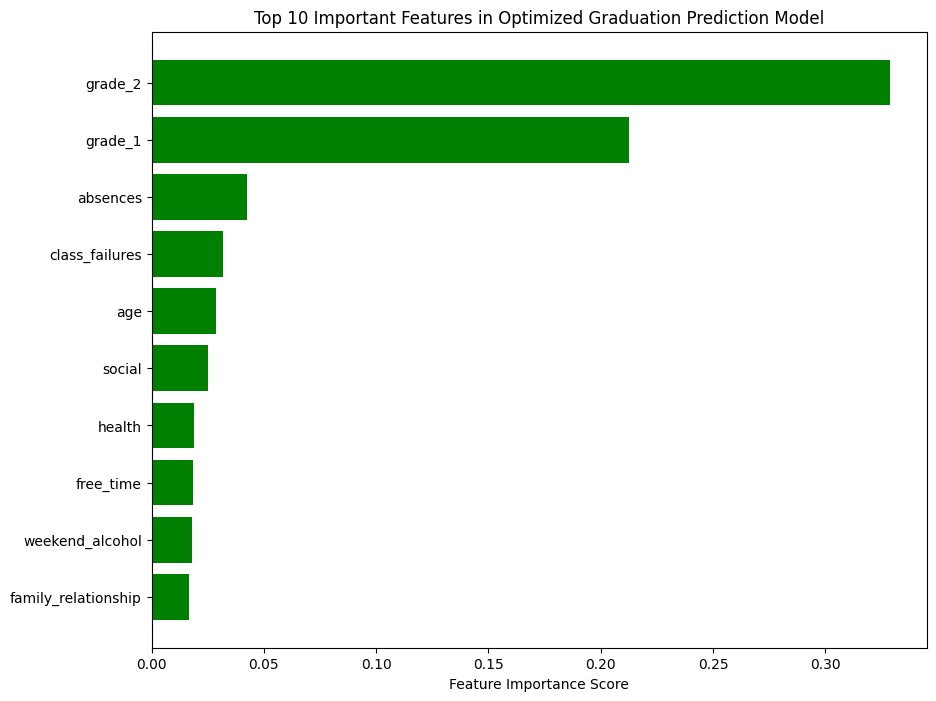

In [15]:
# Get feature importances from the optimized model
importances_opt = optimized_rf_model.feature_importances_
indices_opt = importances_opt.argsort()[::-1]
features_sorted_opt = [features.columns[i] for i in indices_opt]

# Plot top 10 feature importances
plt.figure(figsize=(10, 8))
plt.barh(features_sorted_opt[:10], importances_opt[indices_opt][:10], color="g")
plt.xlabel("Feature Importance Score")
plt.title("Top 10 Important Features in Optimized Graduation Prediction Model")
plt.gca().invert_yaxis()
plt.show()


In [17]:
## Second Model
# Import necessary libraries
import pandas as pd

# Load the dataset
data = pd.read_csv('xAPI-Edu-Data.csv')  # Adjust the file path if necessary

# Display the first few rows of the dataset
print("Dataset Preview:")
print(data.head())

# Check for any missing values and data types
print("\nMissing Values and Data Types:")
print(data.info())


Dataset Preview:
  gender NationalITy PlaceofBirth     StageID GradeID SectionID Topic  \
0      M          KW       KuwaIT  lowerlevel    G-04         A    IT   
1      M          KW       KuwaIT  lowerlevel    G-04         A    IT   
2      M          KW       KuwaIT  lowerlevel    G-04         A    IT   
3      M          KW       KuwaIT  lowerlevel    G-04         A    IT   
4      M          KW       KuwaIT  lowerlevel    G-04         A    IT   

  Semester Relation  raisedhands  VisITedResources  AnnouncementsView  \
0        F   Father           15                16                  2   
1        F   Father           20                20                  3   
2        F   Father           10                 7                  0   
3        F   Father           30                25                  5   
4        F   Father           40                50                 12   

   Discussion ParentAnsweringSurvey ParentschoolSatisfaction  \
0          20                   Yes      

In [18]:
# Handle any missing values (example: drop rows or fill with median/mean)
data = data.dropna()  # Adjust strategy if necessary based on dataset preview

# One-hot encode categorical variables
data_encoded = pd.get_dummies(data, drop_first=True)

# Preview the encoded data to ensure categorical variables are processed
print("\nEncoded Data Preview:")
print(data_encoded.head())



Encoded Data Preview:
   raisedhands  VisITedResources  AnnouncementsView  Discussion  gender_M  \
0           15                16                  2          20      True   
1           20                20                  3          25      True   
2           10                 7                  0          30      True   
3           30                25                  5          35      True   
4           40                50                 12          50      True   

   NationalITy_Iran  NationalITy_Iraq  NationalITy_Jordan  NationalITy_KW  \
0             False             False               False            True   
1             False             False               False            True   
2             False             False               False            True   
3             False             False               False            True   
4             False             False               False            True   

   NationalITy_Lybia  ...  Topic_Quran  Topic_Scien

In [19]:
# Define binary targets for enrollment and graduation support needs
# Replace 'enrollment_status' and 'final_grade' with the actual column names if they differ
data_encoded['enrollment_likelihood'] = (data_encoded['enrollment_status'] == 'Enrolled').astype(int)
data_encoded['graduation_support_needed'] = (data_encoded['final_grade'] < 10).astype(int)

# Check the distribution of each target variable
print("\nTarget Distributions:")
print("Enrollment Likelihood:")
print(data_encoded['enrollment_likelihood'].value_counts())
print("\nGraduation Support Needed:")
print(data_encoded['graduation_support_needed'].value_counts())


KeyError: 'enrollment_status'

In [20]:
# Drop columns that shouldn't be included as features
features = data_encoded.drop(columns=['student_id', 'enrollment_status', 'final_grade', 'enrollment_likelihood', 'graduation_support_needed'])
target_enrollment = data_encoded['enrollment_likelihood']
target_graduation = data_encoded['graduation_support_needed']

# Confirm the shape of the features and targets
print("\nFeatures Shape:", features.shape)
print("Enrollment Target Shape:", target_enrollment.shape)
print("Graduation Support Target Shape:", target_graduation.shape)


KeyError: "['student_id', 'enrollment_status', 'final_grade', 'enrollment_likelihood', 'graduation_support_needed'] not found in axis"

In [21]:
from sklearn.model_selection import train_test_split

# Split data for enrollment prediction
X_train_enroll, X_test_enroll, y_train_enroll, y_test_enroll = train_test_split(features, target_enrollment, test_size=0.2, random_state=42)

# Split data for graduation support prediction
X_train_grad, X_test_grad, y_train_grad, y_test_grad = train_test_split(features, target_graduation, test_size=0.2, random_state=42)

# Display the shape of each set
print("\nEnrollment Prediction - Training Set Shape:", X_train_enroll.shape)
print("Graduation Support Prediction - Training Set Shape:", X_train_grad.shape)


NameError: name 'target_enrollment' is not defined

In [22]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

# Initialize and train the model for enrollment prediction
rf_enrollment = RandomForestClassifier(random_state=42)
rf_enrollment.fit(X_train_enroll, y_train_enroll)

# Predict on the test set for enrollment
y_pred_enroll = rf_enrollment.predict(X_test_enroll)

# Evaluate enrollment prediction model
print("\nEnrollment Prediction Model Evaluation:")
print("Accuracy:", accuracy_score(y_test_enroll, y_pred_enroll))
print("Precision:", precision_score(y_test_enroll, y_pred_enroll))
print("Recall:", recall_score(y_test_enroll, y_pred_enroll))
print("F1 Score:", f1_score(y_test_enroll, y_pred_enroll))

# Initialize and train the model for graduation support prediction
rf_graduation = RandomForestClassifier(random_state=42)
rf_graduation.fit(X_train_grad, y_train_grad)

# Predict on the test set for graduation support
y_pred_grad = rf_graduation.predict(X_test_grad)

# Evaluate graduation support prediction model
print("\nGraduation Support Prediction Model Evaluation:")
print("Accuracy:", accuracy_score(y_test_grad, y_pred_grad))
print("Precision:", precision_score(y_test_grad, y_pred_grad))
print("Recall:", recall_score(y_test_grad, y_pred_grad))
print("F1 Score:", f1_score(y_test_grad, y_pred_grad))


NameError: name 'X_train_enroll' is not defined

In [23]:
import matplotlib.pyplot as plt

# Feature importance for enrollment prediction
importances_enroll = rf_enrollment.feature_importances_
indices_enroll = importances_enroll.argsort()[::-1]
features_sorted_enroll = [features.columns[i] for i in indices_enroll]

plt.figure(figsize=(10, 8))
plt.barh(features_sorted_enroll[:10], importances_enroll[indices_enroll][:10], color="b")
plt.xlabel("Feature Importance Score")
plt.title("Top 10 Important Features for Enrollment Prediction")
plt.gca().invert_yaxis()
plt.show()

# Feature importance for graduation support prediction
importances_grad = rf_graduation.feature_importances_
indices_grad = importances_grad.argsort()[::-1]
features_sorted_grad = [features.columns[i] for i in indices_grad]

plt.figure(figsize=(10, 8))
plt.barh(features_sorted_grad[:10], importances_grad[indices_grad][:10], color="g")
plt.xlabel("Feature Importance Score")
plt.title("Top 10 Important Features for Graduation Support Prediction")
plt.gca().invert_yaxis()
plt.show()


NotFittedError: This RandomForestClassifier instance is not fitted yet. Call 'fit' with appropriate arguments before using this estimator.